In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score

# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
pca_df = pd.read_csv('pca_df.csv')
df_scaled = pd.read_csv('df_scaled.csv')
df_subset = pd.read_csv('df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

In [4]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [5]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

gaussian_mix_clust = GaussianMixture(random_state=42)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(gaussian_mix_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_subset)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[CV] END .....................................n_components=2; total time=  12.7s
[CV] END .....................................n_components=2; total time=  13.0s
[CV] END .....................................n_components=3; total time=  16.2s
[CV] END .....................................n_components=3; total time=  17.1s
[CV] END .....................................n_components=4; total time=  17.3s
[CV] END .....................................n_components=4; total time=  17.9s
[CV] END .....................................n_components=5; total time=  20.2s
[CV] END .....................................n_components=5; total time=  20.4s
[CV] END .....................................n_components=6; total time=  18.2s
[CV] END .....................................n_components=6; total time=  18.6s
[CV] END .....................................n_components=7; total time=  16.6s
[CV] END .....................................n_components=7; total time=  18.0s
[CV] END ...................

GridSearchCV(cv=2, estimator=GaussianMixture(random_state=42), n_jobs=-1,
             param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7fe304186ac0>, verbose=2)

In [7]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'n_components': 9}
Best Score: 23.81397684931903


In [10]:
gaussian_mix = GaussianMixture(n_components=9, random_state=42, verbose=1)
gaussian_mix.fit(df_scaled)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


GaussianMixture(n_components=9, random_state=42, verbose=1)

In [11]:
with open('results/model_based_opt/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [8]:
with open('results/model_based_opt/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [12]:
labels = gaussian_mix.predict(df_scaled)

In [13]:
len(np.unique(labels))

9

In [14]:
pca_df = pca_df.loc[:,:'PC2']

In [15]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels
df_scaled['asset_id'] = df_subset['asset_id']

In [16]:
df_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/gaussian_mix.csv', index = False)

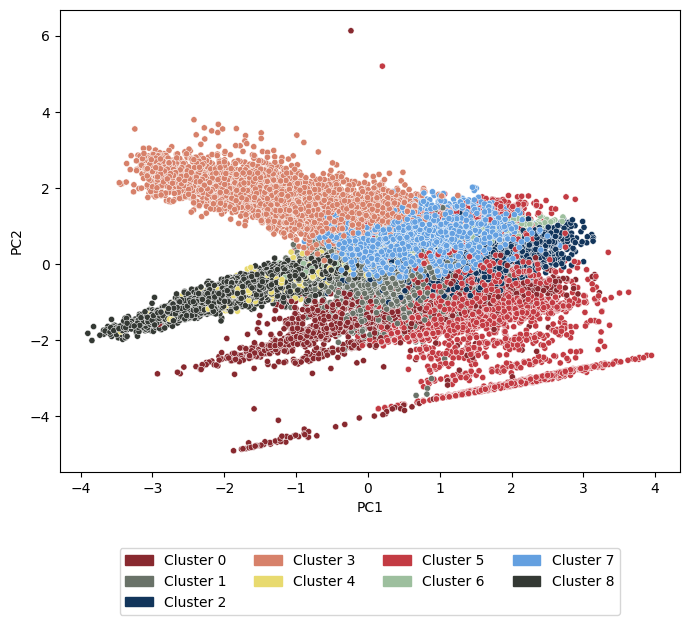

In [17]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [18]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns= 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [19]:
len(most_frequent_clusters.unique())

6

In [20]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [21]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,0
1,12,1.826629,-1.419172,0
2,13,-0.754270,0.041137,8
3,14,0.939960,0.034637,8
4,15,-0.538450,-0.000517,8
...,...,...,...,...
72,510,0.211749,0.019254,3
73,511,0.800390,0.061607,3
74,512,2.197902,-3.128753,3
75,513,-2.400037,2.145315,3


In [22]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 23, 33, 52, 58]
Cluster 1: [34]
Cluster 3: [36, 37, 38, 39, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 5: [26, 57, 62]
Cluster 7: [40]
Cluster 8: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 35, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71]


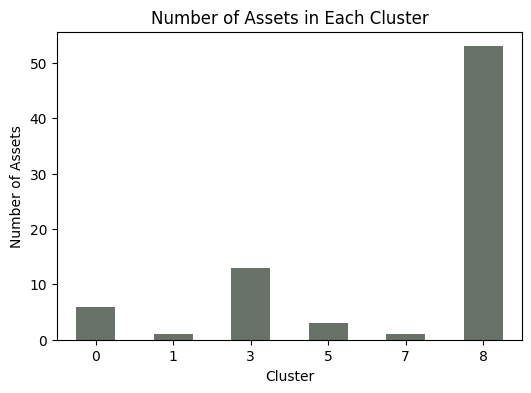

In [23]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [24]:
pca_df.to_csv('results/model_based_opt/labels_most_common/gaussian_mix.csv', index= False)

In [26]:
pca_df = pca_df.loc[:,:'PC2']
df_scaled = df_scaled.loc[:,:'4']

## Bayesian GMM

In [27]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

bgmm_clust = BayesianGaussianMixture(covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(bgmm_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_scaled)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .....................................n_components=2; total time=  11.8s
[CV] END .....................................n_components=2; total time=  14.0s
[CV] END .....................................n_components=3; total time=  16.0s
[CV] END .....................................n_components=3; total time=  16.7s
[CV] END .....................................n_components=5; total time=  23.0s
[CV] END .....................................n_components=5; total time=  23.6s
[CV] END .....................................n_components=4; total time=  23.7s
[CV] END .....................................n_components=4; total time=  24.0s
[CV] END .....................................n_components=6; total time=  26.4s
[CV] END .....................................n_components=6; total time=  26.9s
[CV] END .....................................n_components=7; total time=  35.9s
[CV] END .....................................n_c

GridSearchCV(cv=2,
             estimator=BayesianGaussianMixture(max_iter=1000, random_state=42,
                                               tol=1e-06),
             n_jobs=-1, param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7fe304186ac0>, verbose=2)

In [28]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 3}
Best Silhouette Score: 1.2658862293322062


In [29]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=3, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
bgmm.fit(df_scaled)

# Predicting clusters for data points
labels = bgmm.predict(df_scaled)

In [30]:
with open('results/model_based_opt/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [28]:
with open('results/model_based_opt/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)
labels = bgmm.predict(pca_df)

In [31]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels
df_scaled['asset_id'] = df_subset['asset_id']

In [32]:
df_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/bgmm.csv', index = False)

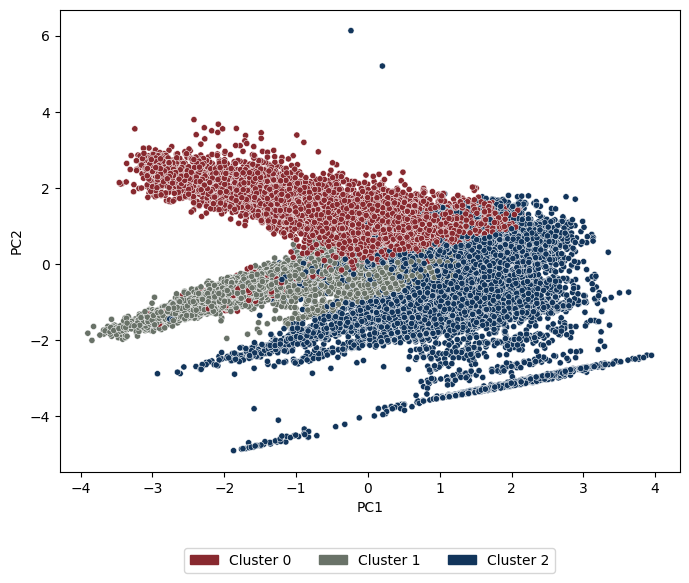

In [33]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [34]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,2
1,0.203757,-1.467581,11,2
2,1.005381,-1.059952,11,2
3,2.111048,-0.849120,11,2
4,-0.148070,-1.640123,11,2


In [35]:
len(most_frequent_clusters.unique())

3

In [36]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,2
1,12,1.826629,-1.419172,2
2,13,-0.754270,0.041137,2
3,14,0.939960,0.034637,1
4,15,-0.538450,-0.000517,2
...,...,...,...,...
72,510,0.211749,0.019254,0
73,511,0.800390,0.061607,0
74,512,2.197902,-3.128753,0
75,513,-2.400037,2.145315,0


In [37]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 1: [3, 5, 8, 14, 25, 28, 29, 31, 35, 60, 64, 65, 66, 70]
Cluster 2: [0, 1, 2, 4, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 32, 33, 34, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 67, 68, 69, 71]


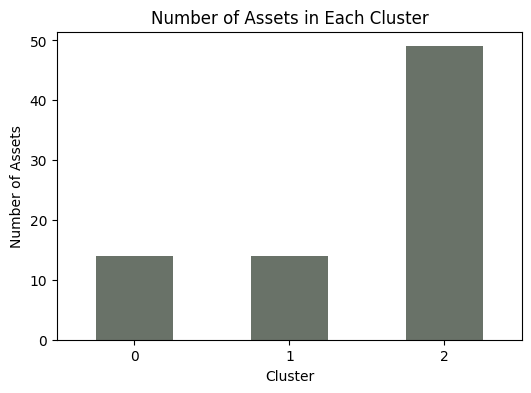

In [38]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [39]:
pca_df.to_csv('results/model_based_opt/labels_most_common/bgmm.csv', index= False)